Start with standard import statements

In [102]:
import graphviz as gv
import numpy as np
import matplotlib.pyplot as plt
import pygraphviz as pgv

# Create and Illustrate the "Web" (Graph)

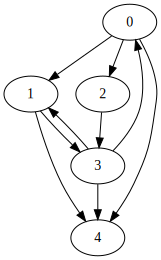

In [103]:
G = pgv.AGraph(directed=True)
G.add_nodes_from([0,1,2,3,4])
#G.add_edges_from(['01', '14', '02', '13', '30', '23', '04', '31','34'])
G.add_edges_from([(0,1), (1,4), (0,2), (1,3), (3,0), (2,3), (0,4), (3,1), (3,4)])

s = G.string()
gdraw = gv.Source(s)
gdraw

# Forming the Matrix
We start with forming the base matrix
Recall random surfer idea:
* "Importance" of a page = probability that we end up at that page
* When at a given node the random surfer chooses an outgoing link
  randomly with equal probability (i.e., a node's importance is
  split evenly between all the outgoing links)

Let:
* $B_k$ be the set of all pages that link to page $k$ (backward links)
* $|B_k|$ be the number of backward links for page $k$
* $F_k$ be the set of all pages that page $k$ links to (forward links)
* $|F_k|$ be the number of forward links from page $k$
* $N$ be the number of pages

Recall formula description:
$$p_k = \sum_{j \in B_k} \frac{p_k}{|F_j|}$$
This tells us that we need the importance for the other pages to compute the importance of a page.  This importance changing will then change the importance of the other pages.  We can update the importances in an iterative manner until they stop changing (convergence).
Pages with no outgoing links are assumed to link to all of the other pages.
We can represent one iteration as a matrix-vector multiplication $\mathbf{Ap}$. 
$$A_{ij} =
\begin{cases}
\frac{1}{|F_j|} \quad \text{if } j \rightarrow i \\
0 \quad \text{otherwise}
\end{cases}$$

In [104]:
n = G.number_of_nodes()
A = np.zeros((n,n))
# Go through by nodes
# For each node, fill in all contributions (i.e., fill by column)
for idx, node in enumerate(sorted(G.nodes())):
    num_forward = G.out_degree(node)
    if num_forward == 0:
        A[:,idx] = 1.0/n
    else:
        out_prob = 1.0/num_forward
        for out_edge in G.out_edges(node):
            A[int(out_edge[1]), idx] = out_prob
        
print(np.round(A,4))

[[ 0.      0.      0.      0.3333  0.2   ]
 [ 0.3333  0.      0.      0.3333  0.2   ]
 [ 0.3333  0.      0.      0.      0.2   ]
 [ 0.      0.5     1.      0.      0.2   ]
 [ 0.3333  0.5     0.      0.3333  0.2   ]]


### Another way of thinking about the matrix formulation
Consider starting on Page 0. After the
random surfer clicks 1 link, he should be on
either Page 1, Page 2, or Page 4, all with equal
probability.  We can test this by multiplying
by a vector of the initial probabilites.  
In this example, initial vector would be 
$$\mathbf{p}^{(0)} = \begin{bmatrix} 1 \\ 0 \\ 0 \\ 0 \\ 0\end{bmatrix}$$
because the surfer started on Page 0 (so 100% probability
for Page 0 initially).
After 1 click (given by formula above), should give
$$\mathbf{p} = \begin{bmatrix} 0 \\ 1/3 \\ 1/3 \\ 0 \\ 1/3\end{bmatrix}.$$
This tells us how we should form the first column of the matrix as this should be given by
as $\mathbf{Ap}^{(0)}$.  The same logic can be used to form the other columns (or verify their correctness).

# Adding in the Damping Factor
Recall that the surfer eventually gets bored and starts on another random page.  This is incorporated via a damping factor:
$$p_k = \frac{(1-d)}{n} + d \sum_{j \in B_k} \frac{p_k}{|F_j|}$$

# The Full Process
Formulating the entire iterative process in matrix form gives
$$\mathbf{p}^{(t+1)} = \left(\frac{(1-d)}{n}\mathbf{E} + d\mathbf{A}\right) \mathbf{p}^{(t)},$$
where $\mathbf{E}$ is the matrix of all 1s.
To get the page rankings, we run this until the page rankings have converged.  This is called a steady state and the entries represent the probability of ending up at that page and correspond to the importance of the page.  The rankings are determined by these importance measrures.
### Create the full matrix (incorporating dampening)

In [105]:
d = 0.85 # Typical d used for page rank
M = np.ones((n,n))*(1.0-d)/n + d*A
print(M)

[[ 0.03        0.03        0.03        0.31333333  0.2       ]
 [ 0.31333333  0.03        0.03        0.31333333  0.2       ]
 [ 0.31333333  0.03        0.03        0.03        0.2       ]
 [ 0.03        0.455       0.88        0.03        0.2       ]
 [ 0.31333333  0.455       0.03        0.31333333  0.2       ]]


### Creating starting vector of probabilities (importances)
In principle, **almost** any vector summing to 1 would work.
Typical is to start with vector with equal elements (i.e.,
equal probability of being on any page at start).

In [106]:
p = np.ones(n, dtype=float)/n

[ 0.12066667  0.17733333  0.12066667  0.319       0.26233333]
[ 0.16498     0.19916889  0.10878556  0.25253     0.27453556]
[ 0.14822121  0.19496554  0.12341538  0.25378554  0.27961232]
[ 0.14944     0.19143601  0.1195301   0.26529752  0.27429637]
[ 0.15179801  0.19413935  0.11897172  0.25959127  0.27549965]
[ 0.1503858   0.19339524  0.11984438  0.26047012  0.27590446]
[ 0.15070363  0.19331294  0.11951307  0.26096446  0.27550591]
[ 0.15077593  0.1934753   0.11953537  0.26058011  0.27563329]
[ 0.15068869  0.19340854  0.11957751  0.26068972  0.27563554]
[ 0.15072013  0.19341526  0.11955317  0.26069755  0.27561389]
[ 0.15071867  0.1934227   0.1195584   0.26067604  0.27562419]
[ 0.15071432  0.19341795  0.11955973  0.2606854   0.2756226 ]
[ 0.1507167   0.1934191   0.11955823  0.26068424  0.27562172]
[ 0.15071623  0.19341929  0.11955876  0.26068331  0.27562241]
[ 0.15071608  0.19341901  0.11955874  0.26068396  0.27562221]
[ 0.15071623  0.19341912  0.11955867  0.26068379  0.2756222 ]
[ 0.1507

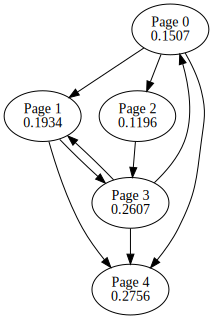

In [107]:
for i in range(20):
    p = np.dot(M, p)
    print(p)
    
for node in G.nodes():
    node.attr['label'] = 'Page {}\n{}'.format(int(node), round(p[int(node)],4))
s = G.string()
gdraw = gv.Source(s)
gdraw

### Fun Facts:
* This model is called a Markov chain (each state depends only on the previous state).
* The iterative process is called power iteration.
* The resulting probability vector (importance values) is actually just the dominant eigenvector (and is guaranteed to exist and be unique up to sign)

In [108]:
# Printing dominant eigenvector for comparison
eigvals, eigvecs = np.linalg.eig(M)
max_ind = np.argmax(np.abs(eigvals))
max_vec = eigvecs[:, max_ind]
max_vec = max_vec / np.linalg.norm(max_vec, ord=1)
print(np.round(max_vec,4))

[-0.1507+0.j -0.1934+0.j -0.1196+0.j -0.2607+0.j -0.2756+0.j]
